In [1]:
from cre import *
from parser import get_parser
from dataset import get_dataset

- Honest Splitting
- Discovery Step:
    ITE Estimation
    Rules Generation
      18 rules generated
    Rules Filtering
      18 rules filtered
    Rules Selection
      2 candidate rules selected
- Inference Step:
    ITE Estimation
    AATE estimatation
                   coef       std err             t  P>|t|  [0.025  0.975]
                                                                          
ATE              -0.016  2.700000e-02 -5.960000e-01  0.552  -0.069   0.037
x1>0.5 & x2<=0.5 -1.000  2.060000e-17 -4.870000e+16  0.000  -1.000  -1.000
x5>0.5 & x6<=0.5  1.000  2.130000e-17  4.710000e+16  0.000   1.000   1.000


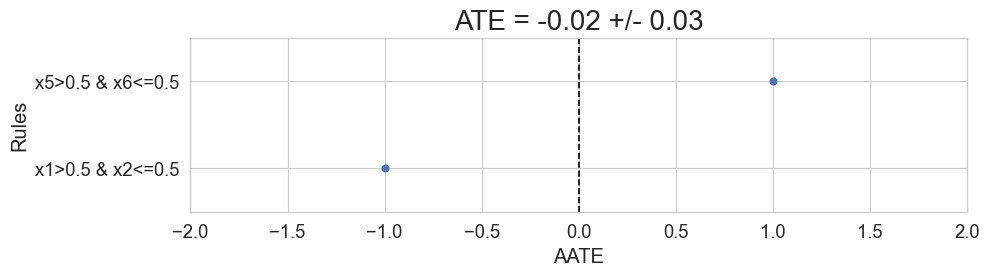

In [4]:
args = get_parser().parse_args(args=[])

dataset = get_dataset(args)

model = CRE(args)
model.fit(dataset)
model.plot()

ite = model.eval(dataset)